<a href="https://colab.research.google.com/github/em-chiu/intersection_project/blob/main/EC%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import urllib.request
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
import numpy as np
from collections import Counter
from sklearn import preprocessing
import string
nltk.download('averaged_perceptron_tagger') # to solve pos feature extract issue
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

import pandas as pd # data processing
import csv
import sys
import unidecode
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emilychiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load the data to df, try1 works
df = pd.read_csv('FTR_labels_copy.csv', header=None, encoding = "ISO-8859-1")\
        .drop(0, axis=1)\
        .rename(columns={1: 'tweet'})

In [3]:
# preview data
df.head()

,tweet,2
0,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0


In [4]:
# Drop first row 
# by selecting all rows from first row onwards
df = df.iloc[1: , :]

In [5]:
# view dimensions of dataset
df.shape
# 2857 instances and 2 attributes in dataset

(2856, 2)

In [6]:
# Rename column names
col_names = ['tweet', 'label']
df.columns = col_names
df.columns

Index(['tweet', 'label'], dtype='object')

In [7]:
# preview after renaming
df.head()

,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0
5,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1


In [8]:
# summary of data
df.info()
# no missing data
# Categorical variables have data type object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 1 to 2856
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2856 non-null   object
 1   label   2856 non-null   object
dtypes: object(2)
memory usage: 44.8+ KB


In [9]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['tweet', 'label']


In [10]:
# view the categorical variables
df[categorical].head()

,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0
5,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1


In [11]:
# check missing values in categorical variables
df[categorical].isnull().sum()

tweet    0
label    0
dtype: int64

In [12]:
# view frequency counts of values in categorical variables
for var in categorical: 
    print(df[var].value_counts())

# 0        1929
# 1         927

"0. Moi\n                                                                                                                                                    4
@flo__lfc @leo2saucisson @ActuFoot_ CrÃ¨ve                                                                                                                   2
"ððððð\n                                                                                                                                      2
"""A Bright Room Called Day"", la cinglante leÃ§on d'histoire de Tony Kushner. Ma critique dans Les SoirÃ©es de Paris â¶ï¸Â https://t.co/Ydl1PqJv7AÂ \n    2
"En ce moment sur LFM #CrÃ¨ve-cÅur#Mauvais Åil et toujours Le Morning sur LFM de 07h Ã  10h du Lundi au Vendredi.\n                                        2
                                                                                                                                                            ..
de toutes faÃ§ons, c'est une mascarade. person

In [13]:
# view frequency distribution of categorical variables
for var in categorical:   
    print(df[var].value_counts()/float(len(df)))

"0. Moi\n                                                                                                                                                    0.001401
@flo__lfc @leo2saucisson @ActuFoot_ CrÃ¨ve                                                                                                                   0.000700
"ððððð\n                                                                                                                                      0.000700
"""A Bright Room Called Day"", la cinglante leÃ§on d'histoire de Tony Kushner. Ma critique dans Les SoirÃ©es de Paris â¶ï¸Â https://t.co/Ydl1PqJv7AÂ \n    0.000700
"En ce moment sur LFM #CrÃ¨ve-cÅur#Mauvais Åil et toujours Le Morning sur LFM de 07h Ã  10h du Lundi au Vendredi.\n                                        0.000700
                                                                                                                                                               ...   
de t

In [14]:
# # check frequency distribution of values in label variable
df.label.value_counts()

0    1929
1     927
Name: label, dtype: int64

In [15]:
# Lowercase all words
def make_lower(a_string):
    return a_string.lower()

df['lowered_tweet'] = df['tweet'].apply(make_lower)
df['lowered_tweet']

1       elle ne devait pas dã©gager la nazi ??? https:...
2       je dois faire un oral en anglais sur hitler et...
3       @ambrassmoi_ a ã§a ð¤ de ressembler ã  la cr...
4       "par curiositã©, jâai voulu ã©couter les dis...
5       @tical10 @exbarcafan74523 @conflitsfrance mdr ...
                              ...                        
2852                           kevin câest un sal noir.
2853    bougnoule bamboula sale arabe , elle est belle...
2854      @b_mahrezz tu viens de le traiter de sal noir ?
2855                     sal noir https://t.co/jraabftel8
2856    sal noir https://t.co/9sr7f4mzr5 https://t.co/...
Name: lowered_tweet, Length: 2856, dtype: object

In [16]:
tokenizer = nltk.TweetTokenizer()
# keeps hashtags together, subset of word_tokenize

df['tokenized_tweet'] = df['lowered_tweet'].apply(tokenizer.tokenize)
df.head()

# https://stackoverflow.com/questions/48363461/passing-a-pandas-dataframe-column-to-an-nltk-tokenizer
#df['tweet'] = df['tweet'].apply(nltk.TweetTokenizer)
# this overwrote what i did

,tweet,label,lowered_tweet,tokenized_tweet
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1,elle ne devait pas dã©gager la nazi ??? https:...,"[elle, ne, devait, pas, dã, ©, gager, la, nazi..."
2,je dois faire un oral en anglais sur Hitler et...,0,je dois faire un oral en anglais sur hitler et...,"[je, dois, faire, un, oral, en, anglais, sur, ..."
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0,@ambrassmoi_ a ã§a ð¤ de ressembler ã la cr...,"[@ambrassmoi_, a, ã, §, a, ð, , ¤, , de, res..."
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0,"""par curiositã©, jâai voulu ã©couter les dis...","["", par, curiositã, ©, ,, jâ, , , ai, voulu,..."
5,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1,@tical10 @exbarcafan74523 @conflitsfrance mdr ...,"[@tical10, @exbarcafan74523, @conflitsfrance, ..."


In [17]:
def rejoin_string(a_list):
    return ' '.join(a_list)

df['tokenized_tweet_joined'] = df['tokenized_tweet'].apply(rejoin_string)

In [18]:
# # df['tweet'] = df['tweet'].astype(pd.StringDtype())

# df['tokenized_tweet'] = df['tokenized_tweet'].astype(str)
# # must feed str into vectorizer

In [19]:
X = df['tokenized_tweet_joined'] # list of tokenized tweets
y = df['label'] # list of labels of tweets

In [20]:
# split X and y into training and testing sets
# randomizes data in splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# indicating random state ensures data split will be same
#https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn

In [21]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape
# ((2284, 10), (572, 10))

((2284,), (572,))

In [22]:
y_train.shape, y_test.shape
# ((2284,), (572,))

((2284,), (572,))

In [23]:
# check data types in X_train

X_train.dtypes

dtype('O')

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize our vectorizer (featurizer, turning text to numbers)
#only looking at numbers produced, creating features
# takes each tweet turning into feature vector, each column corresponds to word
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
# range of n-grams in the final matrix as new features

# fit vectorizer w/ train data (training data)
# This makes your vocab matrix, learns words in vocab
vectorizer.fit(X_train)

# This transforms your documents into vectors (numbers).
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [25]:
# function to test and evaluate models. 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# For plotting
import matplotlib.pyplot as plt

def build_and_eval_model(model, X, y):
    print("Running report for model:", model) 
    
    # Fit our model.
    model.fit(X_train, y_train)
    
    
    # predicting results based on testing data
    y_pred = model.predict(X_test)
    # Make predicted probabilites of our testing data
#     y_pred_proba = model.predict_proba(X_test)
# https://stackoverflow.com/questions/15111408/how-does-sklearn-svm-svcs-function-predict-proba-work-internally

    # Get the evaluation metrics 
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    # y_test are true class labels and y_pred are predicted class labels in test-set, don't use train data
    
    # f1-score is always lower than accuracy measures, they embed precision and recall into their computation
#     print('F1 Score: %.4f' % f1_score(y_test, y_pred, pos_label='0'))
    # https://datascience.stackexchange.com/questions/54436/valueerror-pos-label-1-is-not-a-valid-label-arrayn-y-dtype-u1
    # data not much, low f1score; cross fold validation to generate data articificially
    f1score = f1_score(y_test, y_pred, average='macro')
    print('macro F-1 score : {}'.format(np.round(f1score,5)))
    # macro avg f1score = unweighted mean of all the per-class F1 scores, treats all classes equally important
    # weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class’s support
    ## ‘weight’ refers to proportion of each class’s support relative to the sum of all support values
    # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
    
    # compare the train-set and test-set accuracy to check for overfitting 
    y_pred_train = model.predict(X_train) 
    # overlearned training data = training accuracy higher (but not over so b/c not 99)
    ## close enough to "possibly" overfit but not dramatic difference --> trust model accuracy score (minor point)
    print('Training set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
    print('Test set accuracy score: {:.4f}'.format(model.score(X_test, y_test)))

    # Print the classification report. 
    print(metrics.classification_report(y_test, y_pred))
    
        
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model, 
                                  X=X_test, 
                                  y_true=y_test, 
                                  ax=ax)
    
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

#     # visualize confusion matrix with seaborn heatmap
#     cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
#                                  index=['Predict Positive:1', 'Predict Negative:0'])
#     sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    
    
    # print classification accuracy, same as test set score & model accuracy score
    classification_accuracy = (cm[0,0] + cm[1,1]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
    
    # print classification error
    classification_error = (cm[0,1] + cm[1,0]) / float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    print('Classification error : {0:0.4f}'.format(classification_error))

    # Return the fitted model. 
    return model


Running report for model: LogisticRegression()
Model accuracy score: 0.7570
macro F-1 score : 0.67523
Training set accuracy score: 0.8647
Test set accuracy score: 0.7570
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       390
           1       0.71      0.40      0.51       182

    accuracy                           0.76       572
   macro avg       0.74      0.66      0.68       572
weighted avg       0.75      0.76      0.73       572

Confusion matrix

 [[360  30]
 [109  73]]

True Positives(TP) =  360

True Negatives(TN) =  73

False Positives(FP) =  30

False Negatives(FN) =  109
Classification accuracy : 0.7570
Classification error : 0.2430


LogisticRegression()

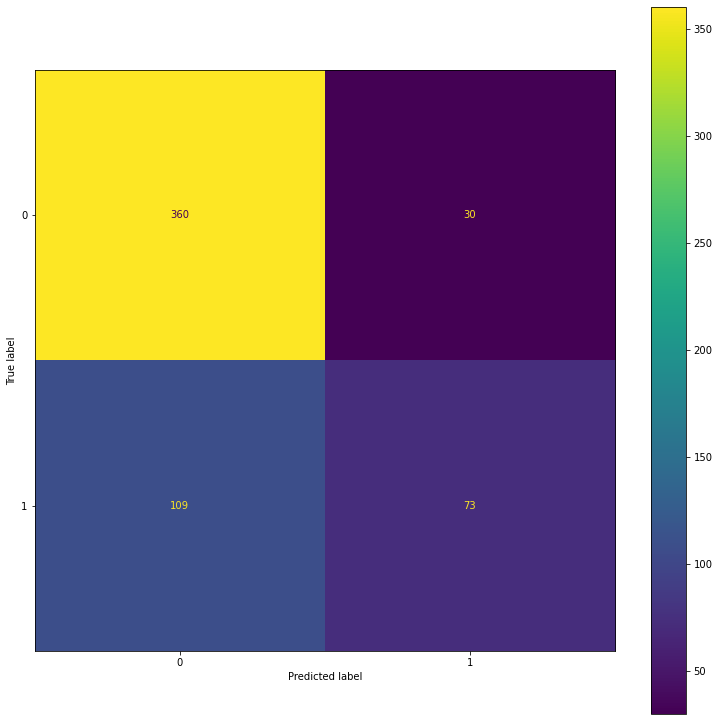

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
build_and_eval_model(lr, X, y)

Running report for model: LinearSVC()
Model accuracy score: 0.7955
macro F-1 score : 0.75801
Training set accuracy score: 0.9974
Test set accuracy score: 0.7955
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       390
           1       0.70      0.63      0.66       182

    accuracy                           0.80       572
   macro avg       0.77      0.75      0.76       572
weighted avg       0.79      0.80      0.79       572

Confusion matrix

 [[340  50]
 [ 67 115]]

True Positives(TP) =  340

True Negatives(TN) =  115

False Positives(FP) =  50

False Negatives(FN) =  67
Classification accuracy : 0.7955
Classification error : 0.2045


LinearSVC()

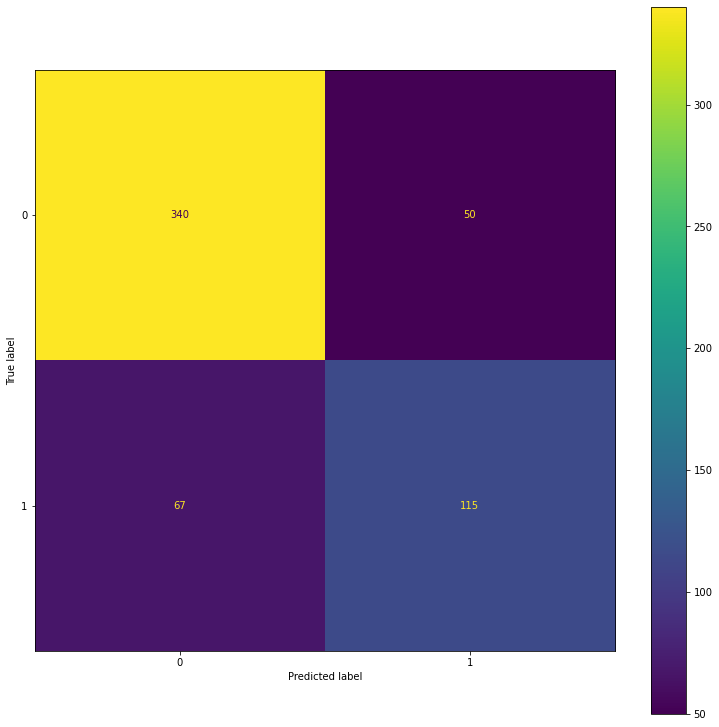

In [27]:
from sklearn import svm

lsvc = svm.LinearSVC()
build_and_eval_model(lsvc, X, y)
# class is imbalanced but not a lot of data is impacting 0 detection better

Running report for model: MultinomialNB(alpha=0.05)
Model accuracy score: 0.7483
macro F-1 score : 0.66742
Training set accuracy score: 0.9943
Test set accuracy score: 0.7483
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       390
           1       0.68      0.40      0.50       182

    accuracy                           0.75       572
   macro avg       0.72      0.66      0.67       572
weighted avg       0.74      0.75      0.73       572

Confusion matrix

 [[355  35]
 [109  73]]

True Positives(TP) =  355

True Negatives(TN) =  73

False Positives(FP) =  35

False Negatives(FN) =  109
Classification accuracy : 0.7483
Classification error : 0.2517


MultinomialNB(alpha=0.05)

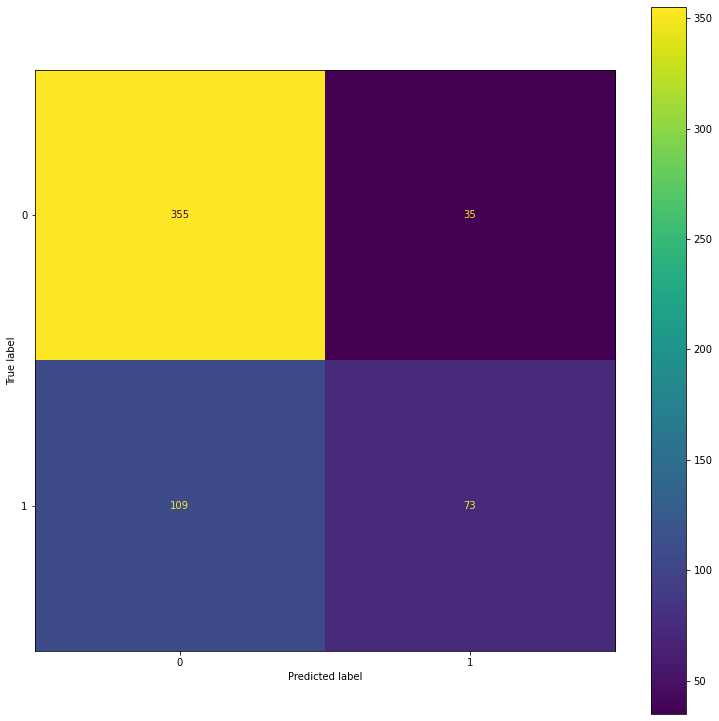

In [28]:
mnb = MultinomialNB(alpha=.05)
build_and_eval_model(mnb, X, y)

Running report for model: SVC()
Model accuracy score: 0.7657
macro F-1 score : 0.68909
Training set accuracy score: 0.9917
Test set accuracy score: 0.7657
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       390
           1       0.73      0.42      0.53       182

    accuracy                           0.77       572
   macro avg       0.75      0.67      0.69       572
weighted avg       0.76      0.77      0.75       572

Confusion matrix

 [[361  29]
 [105  77]]

True Positives(TP) =  361

True Negatives(TN) =  77

False Positives(FP) =  29

False Negatives(FN) =  105
Classification accuracy : 0.7657
Classification error : 0.2343


SVC()

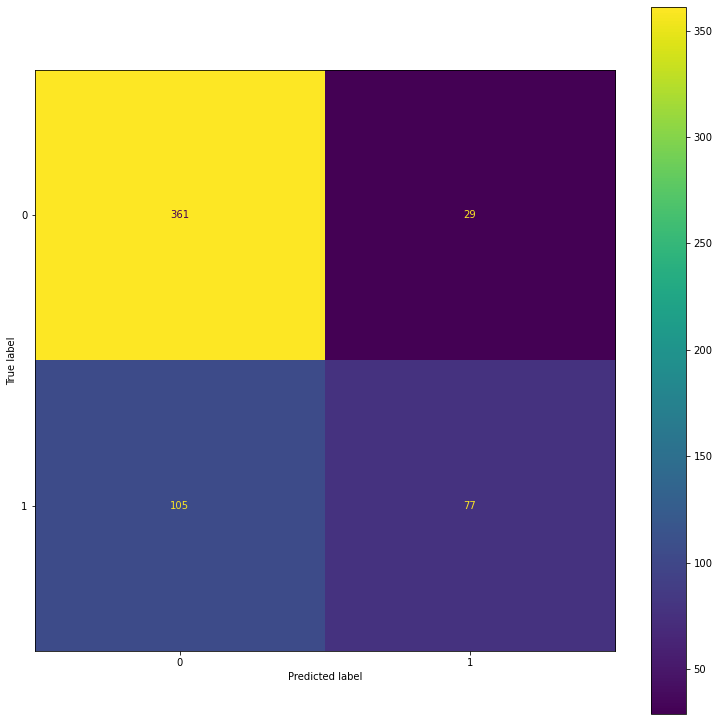

In [29]:
svc = svm.SVC()
build_and_eval_model(svc, X, y)

Running report for model: RandomForestClassifier()
Model accuracy score: 0.7552
macro F-1 score : 0.67811
Training set accuracy score: 0.9996
Test set accuracy score: 0.7552
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       390
           1       0.69      0.42      0.52       182

    accuracy                           0.76       572
   macro avg       0.73      0.67      0.68       572
weighted avg       0.75      0.76      0.74       572

Confusion matrix

 [[356  34]
 [106  76]]

True Positives(TP) =  356

True Negatives(TN) =  76

False Positives(FP) =  34

False Negatives(FN) =  106
Classification accuracy : 0.7552
Classification error : 0.2448


RandomForestClassifier()

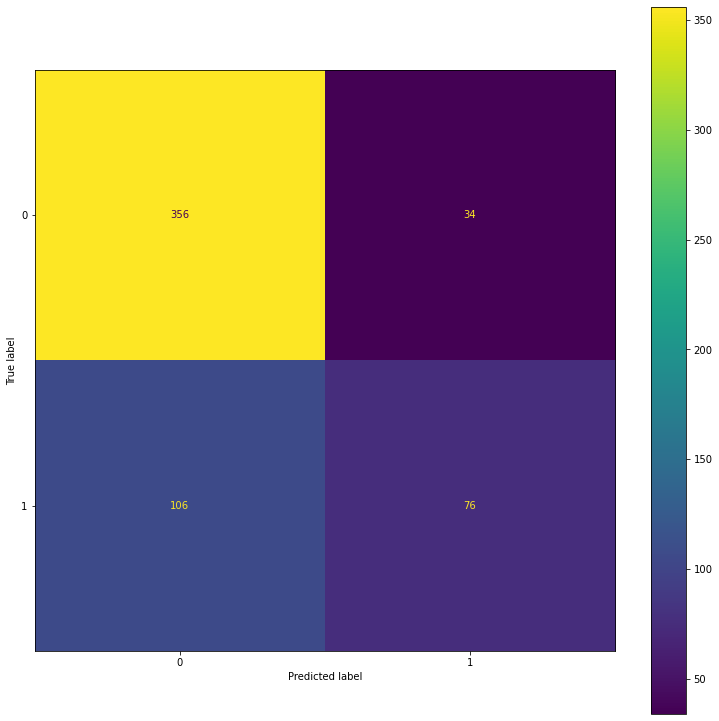

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

build_and_eval_model(rf, X, y)

Running report for model: DecisionTreeClassifier(random_state=0)
Model accuracy score: 0.7150
macro F-1 score : 0.67756
Training set accuracy score: 0.9996
Test set accuracy score: 0.7150
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       390
           1       0.55      0.59      0.57       182

    accuracy                           0.72       572
   macro avg       0.67      0.68      0.68       572
weighted avg       0.72      0.72      0.72       572

Confusion matrix

 [[302  88]
 [ 75 107]]

True Positives(TP) =  302

True Negatives(TN) =  107

False Positives(FP) =  88

False Negatives(FN) =  75
Classification accuracy : 0.7150
Classification error : 0.2850


DecisionTreeClassifier(random_state=0)

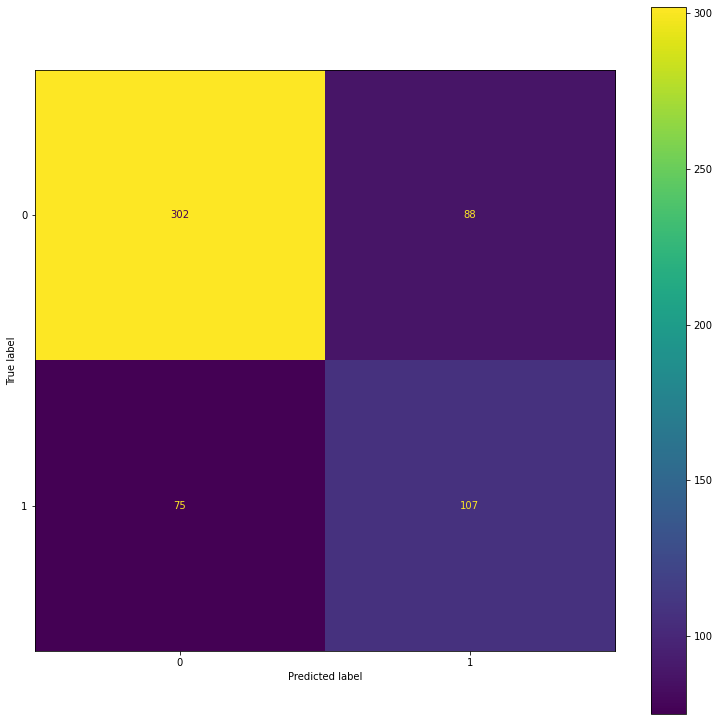

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
build_and_eval_model(dt, X, y)